In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
data = pd.read_csv('full_qad_dataset.csv') 
t_df = data.copy()

In [3]:
t_df.head()

,GST,PRES,WDIR,WSPD,time_stamp,WVHTm
0,11.7,1002.7,W,8.7,2020_01_01 00:00,0.00
1,12.3,1002.8,W,9.0,2020_01_01 00:10,0.00
2,13.0,1003.1,W,9.8,2020_01_01 00:20,0.00
3,12.9,1003.1,W,10.0,2020_01_01 00:30,0.00
4,13.0,1003.0,W,9.7,2020_01_01 00:40,2.68


In [4]:
len(t_df)

43376

In [5]:
t_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43376 entries, 0 to 43375
Data columns (total 6 columns):
GST           43376 non-null float64
PRES          43376 non-null float64
WDIR          43376 non-null object
WSPD          43376 non-null float64
time_stamp    43376 non-null object
WVHTm         43376 non-null float64
dtypes: float64(4), object(2)
memory usage: 2.0+ MB


In [6]:
#meters to feet
t_df['WVHTft'] = 3.281*t_df.WVHTm
t_df.drop('WVHTm', axis = 1, inplace = True)

In [7]:
#get data with wave height
nan_df = t_df.WVHTft > 0
t_df = t_df[nan_df]
len(t_df)

7156

In [8]:
#drop blank WDIR from t_df
blank = t_df.WDIR != "-"
t_df = t_df[blank]
len(t_df)

7156

In [9]:
#dummies
t_df = pd.get_dummies(t_df, columns=['WDIR'])

In [10]:
t_df.head()

,GST,PRES,WSPD,time_stamp,WVHTft,WDIR_E,WDIR_ENE,WDIR_ESE,WDIR_N,WDIR_NE,...,WDIR_NNW,WDIR_NW,WDIR_S,WDIR_SE,WDIR_SSE,WDIR_SSW,WDIR_SW,WDIR_W,WDIR_WNW,WDIR_WSW
4,13.0,1003.0,9.7,2020_01_01 00:40,8.79308,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10,12.6,1003.5,10.0,2020_01_01 01:40,9.41647,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
16,13.2,1003.9,10.5,2020_01_01 02:40,9.02275,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
22,12.6,1003.8,9.3,2020_01_01 03:40,9.25242,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
28,12.9,1003.5,9.7,2020_01_01 04:40,8.82589,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [11]:
t_df.PRES = t_df['PRES'] * .01

In [12]:
X_train, X_valid, Y_train, Y_valid = train_test_split(t_df.drop(['WVHTft', 'time_stamp'], axis = 1),
                                                        t_df['WVHTft'], test_size=0.02)

In [13]:
#run monte carlo simulation and report metrics
scores = []
rmses = []
for i in range(0,1000):
    x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.15)
    reg = Ridge(alpha = .8).fit(x_train, y_train)
    score = reg.score(x_test, y_test)
    scores.append(score)
    preds = reg.predict(x_test)
    rmses.append(np.sqrt(mean_squared_error(y_test, preds)))
print('min_rmse', np.min(rmses))
print('max_scores', np.max(scores))
print('score', reg.score(x_test, y_test))
print('mean_score', np.mean(scores))
print('mean_rmse', np.mean(rmses))

('min_rmse', 2.082025275653641)
('max_scores', 0.5975118865728761)
('score', 0.44656708341565204)
('mean_score', 0.5153693905324986)
('mean_rmse', 2.336769616327199)


In [14]:
#predictions
preds = reg.predict(X_valid)
rmse = np.sqrt(mean_squared_error(Y_valid, preds))
print('MSE: {}' .format(mean_squared_error(Y_valid, preds)))
print('RMSE: {}' .format(rmse))

MSE: 6.42786409946
RMSE: 2.53532327317


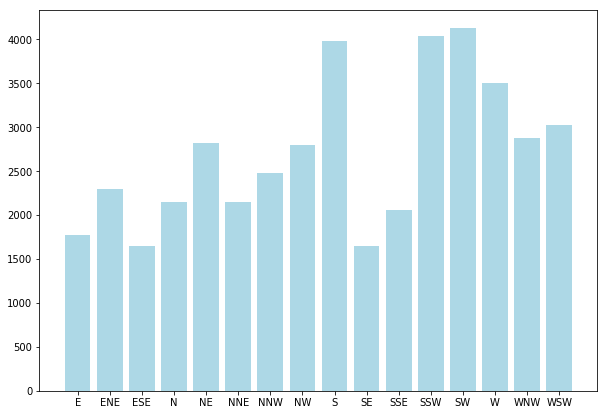

In [15]:
#plot WDIR in df, notice blank
plt.figure(figsize = (10, 7))
wdir_df = pd.DataFrame(data.groupby('WDIR').size(), columns = ['count'])
bar = wdir_df['count'].values
x = wdir_df.index
plt.bar(x, bar, color = 'lightblue');

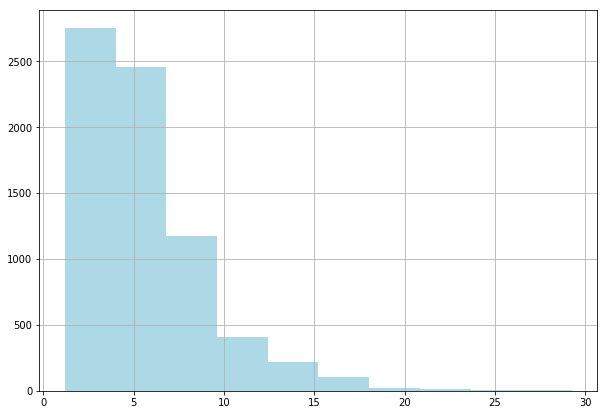

In [16]:
#plot wave height in t_df
plt.figure(figsize = (10, 7))
t_df.WVHTft.hist(color = 'lightblue');

In [17]:
#print coeff for regressor
coefs = list(zip(X_train.columns.tolist(), reg.coef_))
for c in coefs:
    print(c)

('GST', 0.3651130044423813)
('PRES', -6.833287594120217)
('WSPD', 0.13172532927976383)
('WDIR_E', -0.387651643293468)
('WDIR_ENE', 0.4480141506456204)
('WDIR_ESE', -0.6918258008082006)
('WDIR_N', 0.7759823736958378)
('WDIR_NE', 0.6319497715729854)
('WDIR_NNE', 0.4682792094435118)
('WDIR_NNW', 0.6387831658870388)
('WDIR_NW', 0.5119523344997786)
('WDIR_S', -1.0114831402450202)
('WDIR_SE', -0.48296451105227756)
('WDIR_SSE', -0.38757747803344506)
('WDIR_SSW', -0.7654137169603401)
('WDIR_SW', -0.6473338752716953)
('WDIR_W', 0.579312142222662)
('WDIR_WNW', 0.40820117673315753)
('WDIR_WSW', -0.08822415904116986)


In [18]:
len(preds)

144

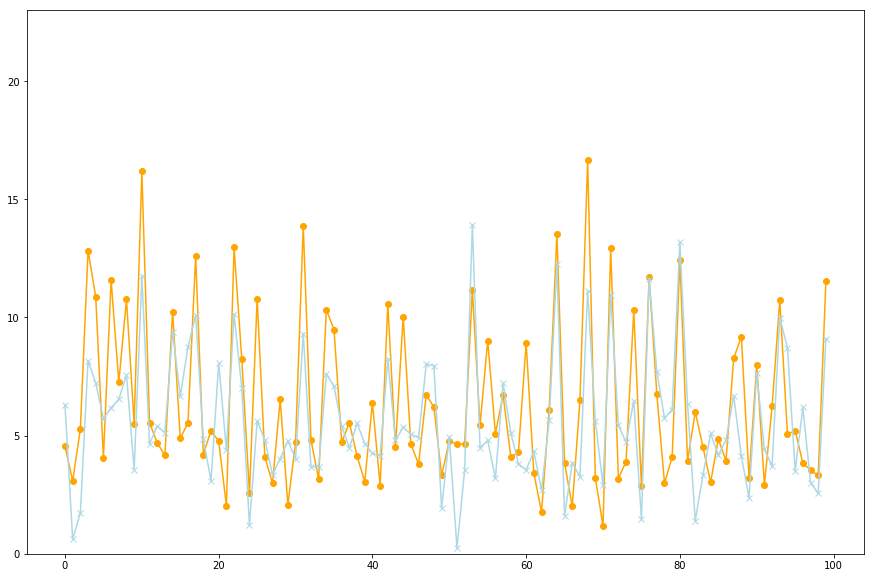

In [19]:
plt.figure(figsize=(15,10))
plt.ylim(0,23)
plt.plot(Y_valid.values[:100], color = 'orange', marker = 'o');
plt.plot(preds[:100], color = 'lightblue', marker = 'x');